In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

Processing: images/coca_retro_1.png
Detected 1 matches in images/coca_retro_1.png.


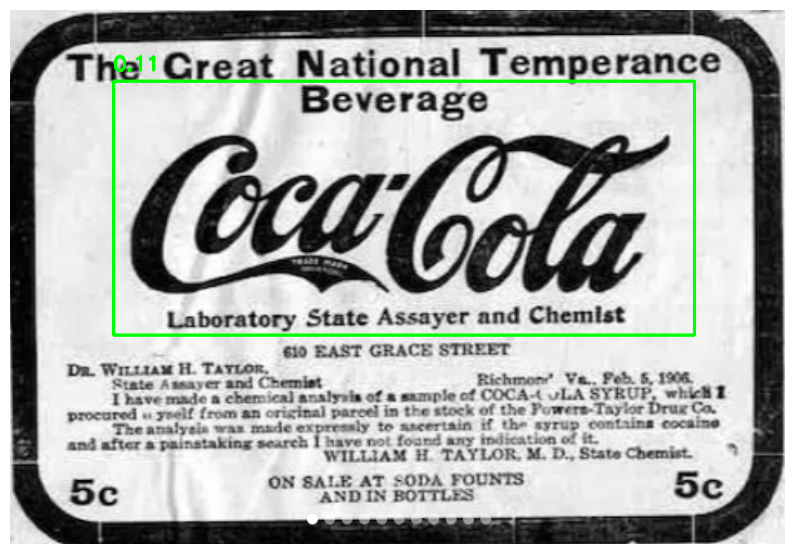

Processing: images/coca_retro_2.png
Detected 1 matches in images/coca_retro_2.png.


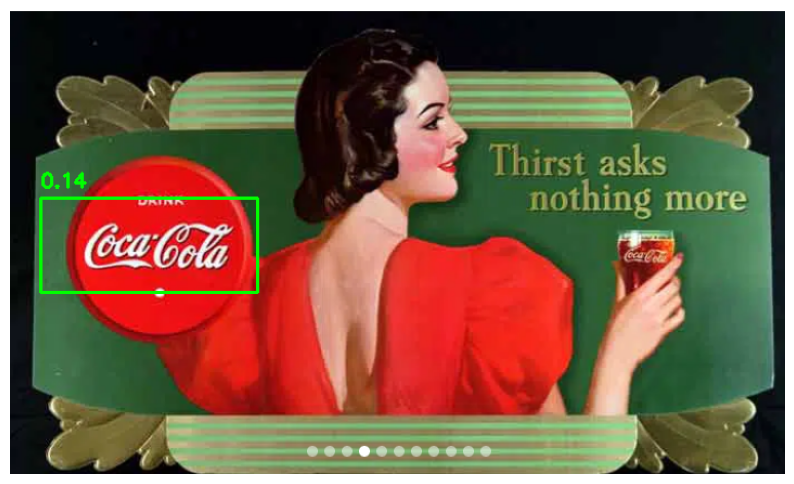

Processing: images/coca_logo_1.png
Detected 1 matches in images/coca_logo_1.png.


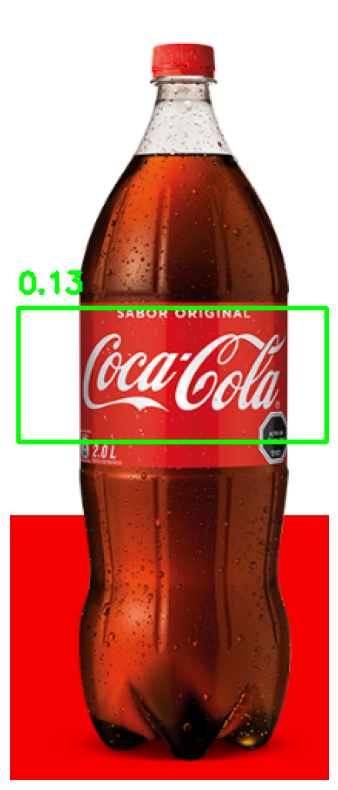

Processing: images/coca_logo_2.png
Detected 1 matches in images/coca_logo_2.png.


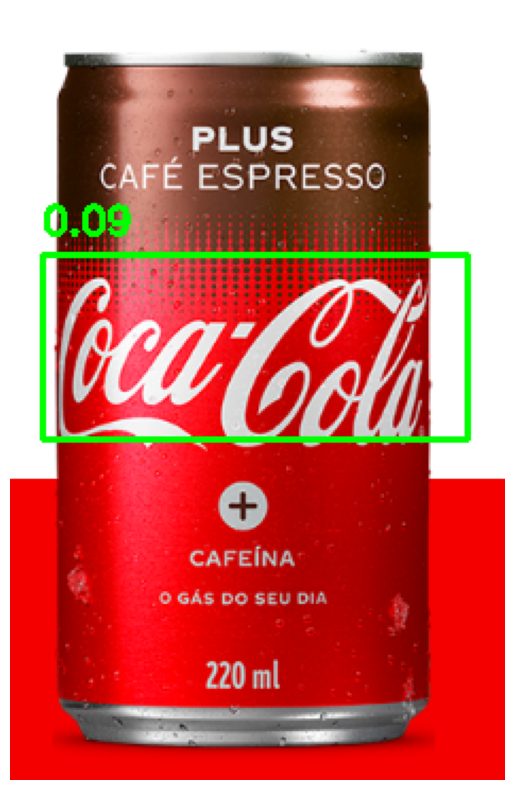

Processing: images/coca_multi.png
Detected 1 matches in images/coca_multi.png.


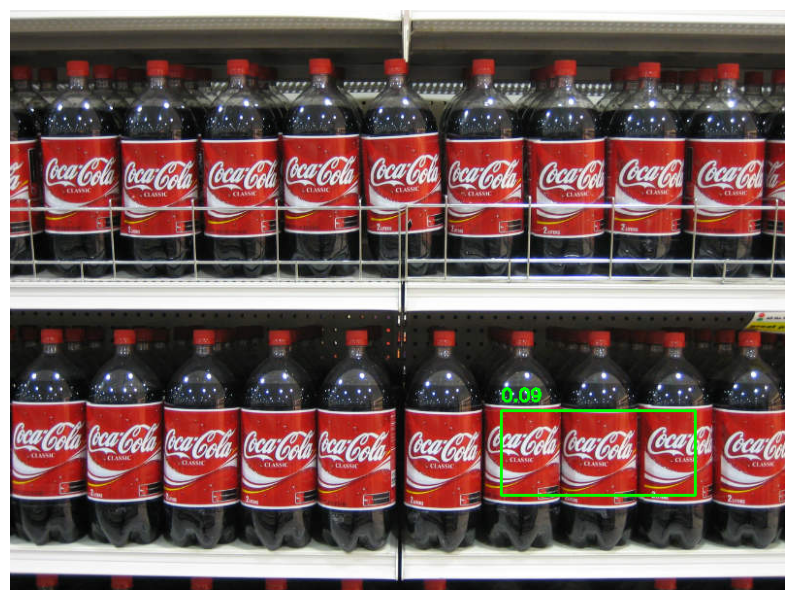

Processing: images/COCA-COLA-LOGO.jpg
Detected 1 matches in images/COCA-COLA-LOGO.jpg.


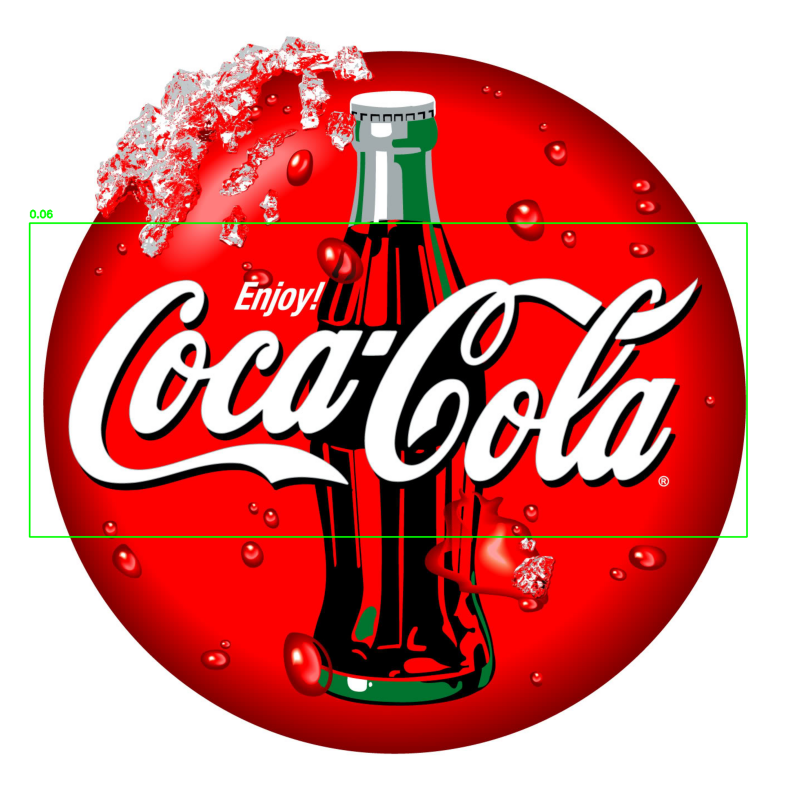

Processing: images/logo_1.png
Detected 1 matches in images/logo_1.png.


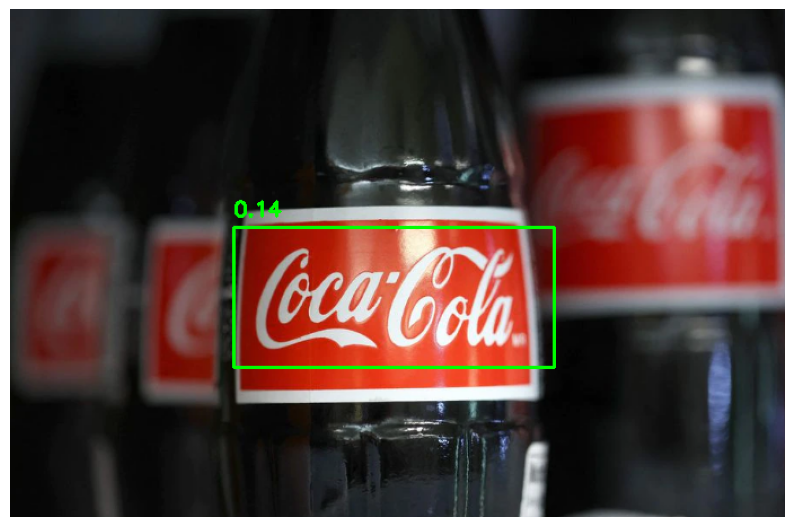

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

template_path = 'template/pattern.png'

image_paths = [
    'images/coca_retro_1.png',
    'images/coca_retro_2.png',
    'images/coca_logo_1.png',
    'images/coca_logo_2.png',
    'images/coca_multi.png',
    'images/COCA-COLA-LOGO.jpg',
    'images/logo_1.png'  
]

# Carga del template
template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)

template_height, template_width = template.shape


def preprocess_template(template):
    """preprocesamiento del template."""
    #normalizamos la imagen
    template = cv2.normalize(template, None, 0, 255, cv2.NORM_MINMAX)
    
    # reducimos el ruido
    template = cv2.bilateralFilter(template, 9, 75, 75)  

    # destacamos los bordes
    template = cv2.Canny(template, 50, 150)  
    return template


def preprocess_image(image):
    """preprocesamiento de las imagenes."""
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.Canny(image, 50, 150)
    return image

# Aplicamos non max suppresion
def non_max_suppression(boxes, confidences, iou_threshold):
    """Evitamos los problemas de superposicion de rectangulos."""
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    confidences = np.array(confidences)

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    area = (x2 - x1) * (y2 - y1)
    order = confidences.argsort()[::-1]

    keep = []
    while len(order) > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)

        intersection = w * h
        iou = intersection / (area[i] + area[order[1:]] - intersection)

        order = order[np.where(iou <= iou_threshold)[0] + 1]

    return boxes[keep], confidences[keep]


def match_template(image, template, threshold, min_size_scale=0.3):
    """Realizamos match template ajustando la escla en base al tamaño de las imagenges."""
    boxes = []
    confidences = []
    for scale in np.linspace(0.5, 4.5, 20):  # Probamos cambiando la escala entre 50 y 450% con un step de 20
        scaled_template = cv2.resize(template, 
                                     (int(template_width * scale), int(template_height * scale)))

        if scaled_template.shape[0] > image.shape[0] or scaled_template.shape[1] > image.shape[1]:
            continue

        result = cv2.matchTemplate(image, scaled_template, cv2.TM_CCOEFF_NORMED)
        locations = np.where(result >= threshold)

        for pt, confidence in zip(zip(*locations[::-1]), result[locations]):
            if min_size_scale * template_width <= scaled_template.shape[1] <= 14 * template_width:
                boxes.append((pt[0], pt[1], scaled_template.shape[1], scaled_template.shape[0]))
                confidences.append(confidence)

    filtered_boxes, filtered_confidences = non_max_suppression(boxes, confidences, iou_threshold=-1)

    return filtered_boxes, filtered_confidences

def visualize_results(image_color, boxes, confidences):
    """ visualicacion de resultados """
    for (x, y, w, h), confidence in zip(boxes, confidences):
        #graficamos el rectangulo con un grosor de 2
        cv2.rectangle(image_color, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # añadimos el valor de confianza del rectangulo
        text = f"{confidence:.2f}"
        cv2.putText(image_color, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.6, (0, 255, 0), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Loop sobre todas las imagenes
for image_path in image_paths:
    print(f"Processing: {image_path}")
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_color = cv2.imread(image_path)

    if image is None:
        raise FileNotFoundError(f"Cannot load image from {image_path}")

    # preprocesamiento
    processed_image = preprocess_image(image)
    processed_template = preprocess_template(template)

    # computamos la relacion de la imagen con el template para ajustar el min_size_scale
    image_width = image.shape[1]
    template_width = template.shape[1]
    width_ratio = image_width / template_width

    
    if width_ratio > 3:
        min_size_scale = 1.4
    else:
        min_size_scale = 0.3

    # Match template
    boxes, confidences = match_template(processed_image, processed_template, threshold=0.01, min_size_scale=min_size_scale)

    if len(boxes) > 0:
        print(f"Detected {len(boxes)} matches in {image_path}.")
        visualize_results(image_color, boxes, confidences)
    else:
        print(f"No matches found in {image_path}.")